<div style="background-color:#003B95; color:#FFFFFF; padding:20px; border-radius:10px; text-align:center">
    <h1 style="color:#FFB700;">LLMs in Action: Scanning, Detecting, & Monitoring Fake & Unsafe Content</h1>
    <h2 style="color:#006CE4;">Part II - Hands On</h2>
    <p style="color:#FFFFFF; font-size:16px;">Presented by: Floriana Zefi</p>
    <p style="color:#FFFFFF; font-size:16px;">Date: 20 November 2024</p>
</div>


Welcome to the hands-on session of **LLMs in Action: How Booking.com Scans, Detects, & Monitors Fake & Unsafe Content**. In this session, we’ll explore the practical aspects of using **LLMs** for detecting and monitoring fake and unsafe content on online platforms.

Using **distilbert-base-uncased** as a foundational model, we’ll cover:
-  Data Preprocessing & Cleaning
-  Text Tokenization and Embedding
-  Pre-Trained vs Fine Tuning BERT Based Models
-  Model Evaluation for Fake Content Detection
-  Practical Tips on Memory Optimization & Efficient Model Use


With Booking.com's commitment to enhancing customer safety and content authenticity, this session will equip you with insights and hands-on skills for applying LLMs in real-world scenarios.


# <span style="color:#003B95">1. Review Dataset Overview</span>

We have a dataset of hotel reviews, with a portion being artificially generated as "fake" reviews. This setup helps simulate real-world scenarios where both genuine and fake content exist, providing a balanced dataset for training and testing our model.
> <span style="color:#FFB700">**Note:**</span> This dataset was generated using Faker and random sampling to create diverse review content for effective model training and testing.


### Import Python Modules

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.display import display, Image
from deep_translator import GoogleTranslator
from PIL import Image as PILImage
from data_processing import evaluate_model_by_language, prepare_data_for_training, compute_metrics, create_sampled_reviews, save_fine_tuned_model, load_fine_tuned_model
from data_processing import preprocess_reviews

import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

pd.options.display.max_colwidth = 500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the Data

In [5]:
df_reviews = pd.read_feather("data/reviews_sample.feather")

## <span style="color:#003B95">1.1 Group Exercises</span>

### <span style="color:#006CE4">Overview of the Activity</span>

This activity is divided into four parts, one for each group. We’ll use Python and some popular data processing libraries to:
1. Calculate and interpret **review length** metrics.
2. Analyze **sentiment trends** in reviews.
3. Examine **language patterns** in real vs. fake content.
4. Brainstorm and identify **distinctive indicators** of fake reviews.


### Notes
- Click on "Show/Hide Solution" to toggle the visibility of the solutions for each group exercise.

---

### Instructions for All Groups

1. **Load and Examine the Data**: Start by loading the dataset and reviewing the initial rows. This will help everyone gain an understanding of its structure and columns, including the review text, language, and whether it’s real or fake.

2. **Group Reflection**: Take a few minutes to read through various reviews. Observe the tone, choice of words, and sentence structure in both real and fake reviews. 

3. **Think-Pair-Share**: Discuss your observations within your group, noting anything unusual or repetitive. We’ll share key takeaways as a whole team once each group completes their task.

---

### Group Exercises

#### <span style="color:#003B95">Group 1: Assessing Average Review Lengths</span>

**Goal**: Identify whether review length can serve as a reliable indicator of authenticity.

*Instructions*: Calculate the average word count for both real and fake reviews.

<details>
    <summary><b><span style="color:gray;">Show/Hide Solution</span></b></summary>

```python
    df_reviews['word_count'] = df_reviews['review'].apply(lambda x: len(x.split()))
    avg_length_real = df_reviews[df_reviews['is_fake'] == 0]['word_count'].mean()
    avg_length_fake = df_reviews[df_reviews['is_fake'] == 1]['word_count'].mean()
    print(f"Real reviews average length: {avg_length_real}, Fake reviews average length: {avg_length_fake}")
```

</details>

<br><br>

#### <span style="color:#003B95">Group 2: Analyzing Sentiment Patterns</span>

**Goal**: Determine if fake reviews exhibit a specific sentiment profile (e.g., overly positive or negative) that differentiates them from real reviews.

*Instructions*: Use sentiment analysis to calculate the polarity of each review.

<details>
    <summary><b><span style="color:gray;">Show/Hide Solution</span></b></summary>

    ```python
    from textblob import TextBlob

    df_reviews['sentiment'] = df_reviews['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    avg_sentiment_real = df_reviews[df_reviews['is_fake'] == 0]['sentiment'].mean()
    avg_sentiment_fake = df_reviews[df_reviews['is_fake'] == 1]['sentiment'].mean()
    print(f"Average sentiment - Real reviews: {avg_sentiment_real}, Fake reviews: {avg_sentiment_fake}")
    ```

</details>

<br><br>

#### <span style="color:#003B95">Group 3: Language Distribution Across Reviews</span>

**Goal**: Investigate if certain languages in the dataset contain a higher proportion of fake reviews.

*Instructions*: Calculate the distribution of real vs. fake reviews across different languages.

<details>
    <summary><b><span style="color:gray;">Show/Hide Solution</span></b></summary>

    ```python
    language_counts = df_reviews.groupby(['language', 'fake']).size().unstack().fillna(0)
    print(language_counts)
    ```

</details>

<br><br>

#### <span style="color:#003B95">Group 4: Identifying Indicators of Fake Reviews</span>

**Goal**: Develop a list of possible indicators of fake reviews based on patterns you observe in the data.

*Instructions*: Review a diverse set of reviews (both real and fake) and compile a list of characteristics that seem common in fake reviews.

<details>
    <summary><b><span style="color:gray;">Show/Hide Solution</span></b></summary>
    <ul>
        <li><b>Repetitive Phrasing</b>: Do you see repeated phrases or templates?</li>
        <li><b>Overly Positive or Generic Language</b>: Are some reviews excessively positive without detail?</li>
        <li><b>Review Lengths</b>: Is there a trend toward very short or excessively long reviews?</li>
        <li><b>Discussion</b>: What other distinguishing traits might help identify fake reviews? How could these features be used in a machine learning model?</li>
    </ul>
</details>

---


# <span style="color:#003B95">2. Exploratory Data Analysis</span>

In this section, we’ll dive into the review dataset to uncover patterns in review length, language usage, and sentiment scores. These insights will inform the development of effective models for detecting fake reviews.

We’ll explore: **Review Length Distribution**, **Language Distribution**, **Sentiment Scores**

---

| language   |      0 |     1 |
|:-----------|-------:|------:|
| ar         |  27143 |  1428 |
| de         |  27143 |  1428 |
| en         | 760000 | 40000 |
| es         |  27143 |  1428 |
| fr         |  27143 |  1428 |
| it         |  27143 |  1428 |
| nl         |  27143 |  1428 |
| zh_CN      |  27143 |  1428 |



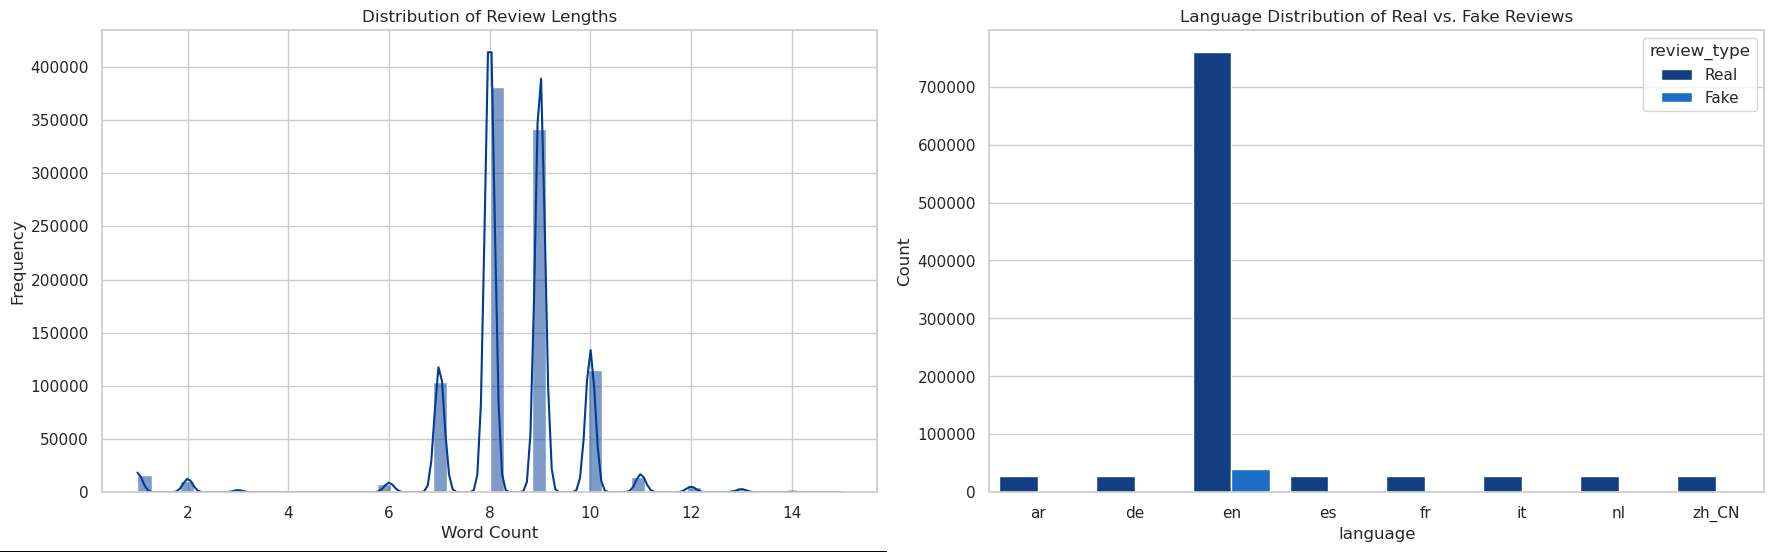

In [6]:
plot1_path = "plots/review_length_distribution.png"
plot2_path = "plots/language_distribution.png"

img1 = PILImage.open(plot1_path)
img2 = PILImage.open(plot2_path)

total_width = img1.width + img2.width
max_height = max(img1.height, img2.height)
combined_img = PILImage.new('RGB', (total_width, max_height))
combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (img1.width, 0))

combined_img.show()

# <span style="color:#003B95">3. Text Preprocessing</span>

Preparing the data is essential for model performance. We will:

- **Tokenize** the review text
- **Remove Stop Words** and unwanted characters
- **Inspect Links** and remove or mask
- **Vectorize** the text for model input

> <span style="color:#FFB700">**Note:**</span> Text preprocessing can significantly impact model results.


In [7]:
df_reviews['review']

0         Mixed feelings. The food was inconsistent, but the overall experience was inconsistent.
1                                        The room was uncomfortable, and the service was poor. 😊🌟
2                                           Great location, but the location was inconsistent. 👎😍
3                        The location was poor, and the service was rude. https://tripadvisor.com
4           I loved my stay here. The staff and the staff were clean. 😊🌟😢 https://tripadvisor.com
                                                   ...                                           
999992                                            كان الموظفون uncomfortable. كان food dirty. 🥰🚫🚫
999993                                           لا تذهب إلى هذا المكان! service كان poor للغاية.
999994                                                    كان room dirty، وكانت الخدمة small. 👍🤔😍
999995                                               تجربة سيئة للغاية. كان room dirty و poor. 👎😢
999996              

In [8]:
df_reviews_cleaned = preprocess_reviews(df_reviews, 
                                        mask_links=False, 
                                        remove_numbers=True, 
                                        remove_special_chars=True)

In [9]:
df_reviews_cleaned[['review', 'processed_review']].head()

,review,processed_review
0,mixed feelings the food was inconsistent but the overall experience was inconsistent,mixed feelings food inconsistent overall experience inconsistent
3,the location was poor and the service was rude https tripadvisor com,location poor service rude https tripadvisor com
4,i loved my stay here the staff and the staff were clean https tripadvisor com,loved stay staff staff clean https tripadvisor com
5,worst stay ever the food was small,worst stay ever food small
9,terrible experience the food was poor and dirty,terrible experience food poor dirty


## <span style="color:#003B95">3.1. Exercise: Comparing Reviews Before and After Cleaning</span>

In this exercise, you’ll explore the impact of text preprocessing on the review data and evaluate how different cleaning parameters influence the results. The goal is to understand how cleaning the data affects the features extracted and to identify potential improvements in preprocessing.

---

### <span style="color:#006CE4">Instructions</span>

#### Step 1: Compare Reviews Before and After Cleaning
1. Load the original and cleaned reviews.
2. Examine the differences between raw reviews and their processed versions.
3. Observe how unwanted text (like links, special characters, or stopwords) is handled by the cleaning function.

<details>
<summary><b><span style="color:gray;">Click for Solution</span></b></summary>

```python

original_reviews = df_reviews['review']
cleaned_reviews = df_reviews['processed_review']

# compare original and cleaned reviews
for i in range(5):  
    print(f"Original Review {i+1}: {original_reviews.iloc[i]}")
    print(f"Cleaned Review {i+1}: {cleaned_reviews.iloc[i]}\n")
```
</details>
<br><br>

#### Step 2: Experiment with Cleaning Parameters
Adjust the parameters of the cleaning function, such as:

- **Minimum and Maximum Review Length**: Exclude overly short or excessively long reviews.
- **Masking Links**: Test whether masking links (e.g., replacing URLs with a placeholder) improves feature consistency.
- **Removing Numbers**: Evaluate if retaining or removing numbers impacts the meaning of reviews.

<details> 
<summary><b><span style="color:gray;">Click for Solution</span></b></summary>

```python
# Experiment with cleaning parameters
df_reviews['processed_review'] = df_reviews['review'].apply(
    lambda x: preprocess_text(
        x,
        mask_links=True,
        remove_numbers=False,  # Change to True/False to experiment
        remove_special_chars=True,
        convert_lowercase=True,
        remove_stopwords=True
    )
)
```
</details>
<br><br>

#### Step 3: Propose New Filters

Based on your observations, think about additional filters or transformations that could enhance data quality. For example:

- **Normalize Emojis into Words**: Convert emojis into descriptive words (e.g., 😊 → "happy").
- **Convert Numbers to a Placeholder**: Replace all numbers with a placeholder (e.g., "123" → "NUM").
- **Retain Domain-Specific Keywords**: Preserve keywords relevant to the dataset (e.g., "hotel", "room").

<details> 
<summary><b><span style="color:gray;">Click for Solution</span></b></summary>

```python
min_length = 5
max_length = 500
df_reviews = df_reviews[df_reviews['processed_review'].apply(lambda x: min_length <= len(x.split()) <= max_length)]

print("Cleaned Data with Adjusted Parameters:")
print(df_reviews['processed_review'].head())
```
</details>


In [10]:
df_reviews_cleaned = preprocess_reviews(df_reviews_cleaned, mask_links=True, 
                               remove_numbers=True, 
                               remove_special_chars=True, 
                               min_length=5, 
                               max_length=500)

# <span style="color:#003B95">4. Setting up and Training the Model – Becoming a Fake Review Detective</span>
In this section, we’ll evaluate a BERT model both **without fine-tuning** (baseline) and **with fine-tuning** on our fake review dataset. This will allow us to see how much specialized training improves its performance.

Let's imagine that our model is like a detective learning to spot fake reviews. Just like a detective, our model will need a specialized toolkit and training to recognize patterns unique to fake content. 

Here’s how we’ll proceed:

---

### <span style="color:#006CE4">1. The Detective Analogy: Turning the Model into a Specialized Expert</span>

Think of the pre-trained model as a generalist detective – someone who has studied language and text in broad terms. But they’re not yet an expert at spotting fake reviews. By fine-tuning, we’ll teach our model to recognize the unique clues that often signal a fake review.

- **Transformers as Language Detectives**: Transformers are skilled at understanding relationships between words. This makes them perfect for spotting the subtle cues that differentiate fake from real content.

### <span style="color:#006CE4">2. Fine-Tuning: Specialized Training for Our Detective</span>

Our pre-trained model has learned general language patterns, but it needs fine-tuning to become a true expert in detecting fake reviews. Fine-tuning is like sending our detective to a "fake review academy," where they learn to recognize specific patterns that distinguish genuine reviews from fake ones.

- **Why Fine-Tuning?** Think of fine-tuning as specialized training for our model. While it already knows general language rules, we now teach it to focus on specific indicators of fake content.
- **Baseline vs. Fine-Tuning Comparison**: By testing the model both with and without fine-tuning, we’ll see how much this specialized training improves its skills.

### <span style="color:#006CE4">3. Baseline Evaluation: How Good Is Our Detective Right Now?</span>

Before fine-tuning, we'll evaluate the model to establish a **baseline** – its performance using only its general language knowledge. This will help us understand how much improvement fine-tuning brings.

#### <span style="color:#FFB700">Metrics We'll Track:</span>

- **Accuracy**: The percentage of correct predictions.
- **Precision**: The proportion of positive predictions that are correct.
- **Recall**: The proportion of actual positives correctly predicted.
- **F1 Score**: A balance between precision and recall, particularly useful for imbalanced datasets.

---
### <span style="color:#006CE4">4. Key Differences Between Pre-Trained (Baseline) and Fine-Tuned Workflows</span>
Before we start, here is a summary of the key differences.

| **Aspect**              | **Baseline (Pre-Trained)**                                | **Fine-Tuned**                                                                   |
|--------------------------|----------------------------------------------------------|----------------------------------------------------------------------------------|
| **Purpose**             | Evaluate the performance of a pre-trained model "as is" | Train the model on specific data to improve performance for a particular task   |
| **Dataset Handling**    | No train-test split is needed. Use a smaller evaluation dataset | Requires train-test split for training and validation                           |
| **Parameter Updates**   | The model weights are **not updated** during evaluation | The model weights are updated during training (fine-tuning)                     |
| **Steps Needed**        | Tokenize and evaluate                                    | Tokenize, train on the training set, and validate on the test set               |


### <span style="color:#006CE4">1. Baseline Evaluation – Using BERT Without Fine-Tuning</span>
First, we’ll use the pre-trained BERT model to classify reviews as real or fake without any additional training. This establishes a baseline for comparison.

---

Let's import the modules and define the parmeters we will use.

In [11]:
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt

from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score

num_labels = 2
label_column_name = "is_fake"
text_column_name = "processed_review"
model_name = "distilbert-base-uncased"

learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 5
test_size = 0.2

> <span style="color:#FFB700">**Note:**</span> For this exercise, we will limit the dataset size to ensure the predictions run efficiently and do not take an extended amount of time.

In [12]:
total_sample_size = 5000
english_sample_size = int(total_sample_size * 0.8)
remaining_sample_size = total_sample_size - english_sample_size

df_reviews_small = create_sampled_reviews(df_reviews_cleaned, total_sample_size=5000, random_state=42)

<table style="width: 100%; table-layout: fixed; height: 400px; border-collapse: collapse;">
<tr>
<td style="vertical-align: top; width: 45%; padding: 15px; font-family: Arial, sans-serif; line-height: 1.6;">

### <span style="color:#003B95; font-weight: bold;">Data Preparation for BERT Classification</span>

#### What Are We Doing?

1. **Load Pre-Trained Tokenizer and Model**:
   - Use `AutoTokenizer` and `AutoModelForSequenceClassification` from Hugging Face Transformers.
   - **Tokenizer**: Converts raw text into numerical tokens.
   - **Model**: Fine-tuned BERT model for sequence classification tasks (e.g., fake review detection).

2. **Define Tokenization Function**:
   - `tokenize_data` processes text by:
     - **Padding**: Adds padding to shorter sequences.
     - **Truncation**: Shortens sequences exceeding a max length.
     - **Max Length**: Ensures sequences are limited (e.g., 128 tokens).

3. **Prepare Evaluation Dataset**:
   - Use `Dataset.from_pandas` to convert a dataframe into Hugging Face format.
   - Apply `tokenize_data` using `.map()` for efficient batch processing.

</td>
<td style="width: 55%; padding: 15px; background-color: #f7f7f7; font-family: Consolas, monospace;">

```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Tokenize data
def tokenize_data(batch):
    return tokenizer(batch[text_column_name], 
                     padding=True, 
                     truncation=True, 
                     max_length=128)

# Prepare evaluation dataset
eval_dataset = Dataset.from_pandas(df_reviews_small).map(tokenize_data, batched=True)


#### <span style="color:#003B95">Why These Libraries?</span>

- **Hugging Face Transformers**: Simplifies model and tokenizer integration for tasks like classification.
- **Datasets Library**: Optimized for large-scale text processing and works seamlessly with Hugging Face models.


In [32]:
def baseline_evaluation(df, text_column_name, label_column_name, model_name, num_labels):
    """
    Perform baseline evaluation without fine-tuning

    Parameters:
    - df: DataFrame containing text and labels
    - text_column_name: Column name for text
    - label_column_name: Column name for labels
    - model_name: Pre-trained model name from Hugging Face
    - num_labels: Number of labels for classification

    Returns:
    - dict: Baseline evaluation metrics
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    dataset = Dataset.from_pandas(df)

    def preprocess_function(examples):
        return tokenizer(examples[text_column_name], truncation=True, padding=True, max_length=128)
    
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    tokenized_dataset = tokenized_dataset.rename_column(label_column_name, "labels")

    baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    training_args = TrainingArguments(
        output_dir="./results_baseline",
        per_device_eval_batch_size=8,
    )

    trainer = Trainer(
        model=baseline_model,
        args=training_args,
        eval_dataset=tokenized_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    eval_results = trainer.evaluate()
    return eval_results


In [33]:
baseline_results = baseline_evaluation(
    df_reviews_small, 
    text_column_name=text_column_name,
    label_column_name=label_column_name, 
    model_name=model_name, 
    num_labels=num_labels
)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?ba/s]

In [34]:
display(baseline_results['eval_f1'])

0.07477341389728097

### <span style="color:#006CE4">2. Fine-Tuning and Evaluating the Model</span>

Next, we’ll fine-tune the BERT model on our fake review dataset, effectively training it to specialize in detecting fake reviews.

> <span style="color:#FFB700">**Note:**</span> The next step is time-intensive and can take several hours to complete. Instead, we will use a pre-trained model that has already been processed, saved, and is ready for use.

In [18]:
def fine_tune_model(df, text_column_name, label_column_name, model_name, num_labels, learning_rate, num_train_epochs, weight_decay, test_size=0.2):
    """
    Fine-tune a pre-trained model.

    Parameters:
    - df: DataFrame containing text and labels.
    - text_column_name: Column name for text.
    - label_column_name: Column name for labels.
    - model_name: Pre-trained model name from Hugging Face.
    - num_labels: Number of labels for classification.
    - learning_rate: Learning rate for fine-tuning.
    - num_train_epochs: Number of training epochs.
    - weight_decay: Weight decay for regularization.
    - test_size: Proportion of data to use as a test set.

    Returns:
    - dict: Fine-tuning evaluation results.
    - Trainer: The fine-tuned Trainer object.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_train, tokenized_test = prepare_data_for_training(df, text_column_name, label_column_name, tokenizer, test_size)

    fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    training_args = TrainingArguments(
        output_dir="./results_finetuned",
        learning_rate=learning_rate,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=fine_tuned_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results, trainer


```python
fine_tune_results, fine_tuned_trainer = fine_tune_model(
    df_reviews_cleaned, 
    text_column_name=text_column_name, 
    label_column_name=label_column_name, 
    model_name=model_name, 
    num_labels=num_labels, 
    learning_rate=learning_rate, 
    num_train_epochs=num_train_epochs, 
    weight_decay=weight_decay, 
    test_size=test_size
)

save_fine_tuned_model(fine_tuned_trainer, 
                      fine_tune_results, 
                      output_dir="./fine_tuned_model")
```

## <span style="color:#003B95">Exercises</span>

---
#### <span style="color:#003B95">Exercise 1: Load the Fine-Tuned Model and Check the Performance</span>

In this exercise, you will explore the results of a fine-tuned model and understand its performance using stored evaluation metrics.

---

**Goal:**
- Use the provided `load_fine_tuned_model` function to load the fine-tuned model, tokenizer, and evaluation results from the directory `./fine_tuned_model`.
- Examine the stored evaluation metric, specifically the **F1 score**, to assess the model's performance.


<details>
    <summary><b><span style="color:gray;">Show/Hide Solution</span></b></summary>

```python
model, tokenizer, eval_results = load_fine_tuned_model(output_dir="./fine_tuned_model")

f1_score = eval_results.get("eval_f1", None)
print("Model Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

if f1_score is not None:
    print(f"F1 Score: {f1_score:.4f}")
else:
    print("F1 Score not found in evaluation results.")

```

</details>

<br><br>

---

#### <span style="color:#006CE4">Exercise 2: Measuring Model Performance Across Languages</span>

**Goal**: Evaluate how well the fine-tuned model classifies reviews in different languages. Identify if the model performs consistently across languages or shows variation, and discuss potential strategies for improvement.

*Instructions*:

1. **Tokenize Reviews by Language**:
2. Evaluate the Model: Use the fine-tuned model to predict reviews for each language. Calculate metrics like accuracy, precision, recall, and F1 score for every language.
3. Summarize the Results: Convert the metrics into a DataFrame and display the F1 scores in descending order.


<details>
    <summary><b><span style="color:gray;">Show/Hide Solution</span></b></summary>

```python
from data_processing import evaluate_model_by_language
model, tokenizer, eval_results = load_fine_tuned_model(output_dir="./fine_tuned_model")
finetuned_model_dir = "./fine_tuned_model"  
model, tokenizer, eval_results = load_fine_tuned_model(output_dir=finetuned_model_dir)

results_df = evaluate_model_by_language(
    model=model,
    tokenizer=tokenizer,
    df=df_reviews_small,
    text_column_name=text_column_name, 
    label_column_name=label_column_name,  
    language_column_name="language"  
)
   
```

</details>

<br><br>

---

If you notice a language with very low performance, consider the following:

Are the reviews in this language significantly shorter or more generic?
Could additional fine-tuning with more data in this language improve results?


#### <span style="color:#006CE4">Exercise 3 (Optional): Go to Hugging Face and search for a differnt model and follow the same steps</span>
*Instructions*: https://huggingface.co/models



In [ ]:
model, tokenizer, eval_results = load_fine_tuned_model(output_dir="./fine_tuned_model")

In [ ]:
finetuned_model_dir = "./fine_tuned_model"  
model, tokenizer, eval_results = load_fine_tuned_model(output_dir=finetuned_model_dir)

results_df = evaluate_model_by_language(
    model=model,
    tokenizer=tokenizer,
    df=df_reviews_small,
    text_column_name=text_column_name, 
    label_column_name=label_column_name,  
    language_column_name="language"  
)

In [ ]:
results_df

### Model Evaluation Metrics by Language

| Language | Accuracy | Precision | Recall   | F1 Score |
|----------|----------|-----------|----------|----------|
| en       | 0.817500 | 1.0       | 0.635000 | 0.776758 |
| fr       | 0.845070 | 1.0       | 0.690141 | 0.816667 |
| nl       | 0.802817 | 1.0       | 0.605634 | 0.754386 |
| it       | 0.838028 | 1.0       | 0.676056 | 0.806723 |
| ar       | 0.823944 | 1.0       | 0.647887 | 0.786325 |
| de       | 0.859155 | 1.0       | 0.718310 | 0.836066 |
| zh_CN    | 0.823944 | 1.0       | 0.647887 | 0.786325 |
| es       | 0.774648 | 1.0       | 0.549296 | 0.709091 |


In [31]:
language_map = {
    'nl': 'dutch',
    'es': 'spanish',
    'ar': 'arabic',
    'fr': 'french',
    'ru': 'russian',
    'it': 'italian',
    'pt_BR': 'portuguese',
    'de': 'german',
    'en': 'english'
}

translation_cache = {}

def cached_translate(text, src_lang):
    if text in translation_cache:
        return translation_cache[text]
    mapped_lang = language_map.get(src_lang, 'auto')
    try:
        translation = GoogleTranslator(source=mapped_lang, target="en").translate(text)
        translation_cache[text] = translation
        return translation
    except Exception as e:
        print(f"Error translating '{text}': {e}")
        return text

df_reviews_small_non_en = df_reviews_small[df_reviews_small['language'] != 'en'].copy()

df_reviews_small_non_en['translated_text'] = df_reviews_small_non_en.apply(
    lambda row: cached_translate(row['review'], src_lang=row['language']), axis=1
)

```python
df_reviews_small_non_en[df_reviews_small_non_en['language']!='en'][["review", "translated_text", "is_fake"]].head()
```


| ID  | Review (Original)                                         | Translated Text                                     | Is Fake |
|-----|----------------------------------------------------------|----------------------------------------------------|---------|
| 17  | fantastique le room était clean et le séjour global était spacious | fantastic the room was clean and the overall stay was spacious | 1       |
| 25  | vermijd deze plek de room was extreem small              | avoid this place the room was extremely small      | 0       |
| 28  | il service era small e il servizio era small             | the service was small and the service was small    | 0       |
| 38  | het personeel was rude de service was rude               | the staff was rude the service was rude            | 0       |
| 43  | تجربة سيئة للغاية كان staff small و poor url booking com | Very bad experience the staff was small and poor url booking com | 1       |



# <span style="color:#003B95">5. Deploying and Testing the Model</span>
### <span style="color:#006CE4">Live Testing</span>
To simulate real-world application, we test the model on new, unseen data to ensure it generalizes well and correctly classifies reviews.

<span style="color:#FFB700">Key Point:</span> Always test models on fresh data before deployment to avoid overfitting and ensure robustness.

In [27]:
new_reviews = ["This hotel was fantastic!", "Terrible experience, will not return."]
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = fine_tuned_trainer.model.to(device)

new_tokens = tokenizer(new_reviews, padding=True, truncation=True, return_tensors="pt").to(device)
outputs = model(**new_tokens)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


```python
for review, prob in zip(new_reviews, probs):
    print(f"Review: {review}")
    print(f"Probabilities: {prob.tolist()}")
    print(f"Predicted Class: {prob.argmax().item()}\n")

```

```
Review: This hotel was fantastic!
Probabilities: [4.1773723369331606e-10, 1.0]
Predicted Class: 1

Review: Terrible experience, will not return.
Probabilities: [0.9925212264060974, 0.007478704210370779]
Predicted Class: 0

# <span style="color:#003B95">6. Practical Tips on Memory Optimization & Efficient Model Use</span>


When working with large language models, memory management and optimization are essential. Here are some practical tips to ensure efficient model usage:

---

### <span style="color:#006CE4">1. Use Smaller Batch Sizes</span>
- Reduces memory consumption during training and evaluation.
- **Example**: `per_device_train_batch_size=4`.

---

### <span style="color:#006CE4">2. Leverage GPU Acceleration</span>
- Use GPUs for faster computations.
- **How to Check**: `torch.cuda.is_available()`.
- **Move Model to GPU**: `model.to('cuda')`.

---

### <span style="color:#006CE4">3. Use Lightweight Models</span>
- Opt for smaller models like `distilbert-base-uncased` or `albert-base-v2`.
- These models are faster and require less memory than larger counterparts.

---

### <span style="color:#006CE4">4. Tokenize in Small Batches</span>
- Prevent memory spikes by setting a smaller batch size during tokenization.
- **Example**: `batch_size=8`.

---

### <span style="color:#006CE4">5. Clear Memory Regularly</span>
- Free up memory between operations to avoid crashes.
- **Example**:
  ```python
  torch.cuda.empty_cache()
  gc.collect()


### <span style="color:#006CE4">6. Mixed Precision Training</span>
Use `fp16=True` for memory-efficient training without significant precision loss.


### <span style="color:#006CE4">7. Monitor System Resources</span>
Track GPU and RAM usage with tools like:
nvidia-smi: GPU monitoring.
psutil: System memory usage.


# <span style="color:#003B95">7. Some Food for Thought</span>

As we explore applying **Large Language Models (LLMs)** to detect fake and unsafe content, here are a few thought-provoking questions to consider:

---

### <span style="color:#006CE4">1. How do you ensure a good model for non-English text?</span>
- LLMs are often pre-trained primarily on English data. How do you address multilingual challenges?
- Should you fine-tune with datasets specific to each language or use multilingual models like `xlm-roberta`?
- How can you measure model performance across different languages?

---

### <span style="color:#006CE4">2. How do you collect and create good-quality labels?</span>
- What strategies can ensure unbiased, consistent, and high-quality annotations?
- Can active learning or model-driven labeling improve labeling efficiency?
- How do you handle subjective cases where content could be labeled differently based on interpretation?

---

### <span style="color:#006CE4">3. How do you ensure no data leakage between train and test sets?</span>
- What steps can you take to avoid overlapping samples or labels across datasets?
- How do you deal with duplicates or near-duplicates in large-scale datasets?
- Why is it critical to prevent data leakage, and how does it affect model evaluation?

---

<span style="color:#FFB700">These questions are critical for ensuring robustness and fairness in your models while working with diverse datasets in real-world scenarios.</span>
